# Modeling and Simulation in Python

Chapter 6

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [58]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html

### Code from the previous chapter



In [59]:
#filename = 'data/World_population_estimates.html'   doesn't work since I don't have that downloaded
filename2 = 'https://en.wikipedia.org/wiki/World_population_estimates'
tables = read_html(filename2, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [60]:
un = table2.un / 1e9  #.un is calling a specific column out of the table and 1e9 is scientific notation
un.head()

Year
1950    2.525149
1951    2.572851
1952    2.619292
1953    2.665865
1954    2.713172
Name: un, dtype: float64

In [61]:
census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

In [62]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
elapsed_time = t_end - t_0

p_0 = get_first_value(census)
p_end = get_last_value(census)
total_growth = p_end - p_0

annual_growth = total_growth / elapsed_time

0.07224800083333333

### System objects

We can rewrite the code from the previous chapter using system objects.

In [63]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
annual_growth,0.072248


And we can encapsulate the code that runs the model in a function.

In [64]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    
    return results

We can also encapsulate the code that plots the results.

In [65]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

Here's how we run it.

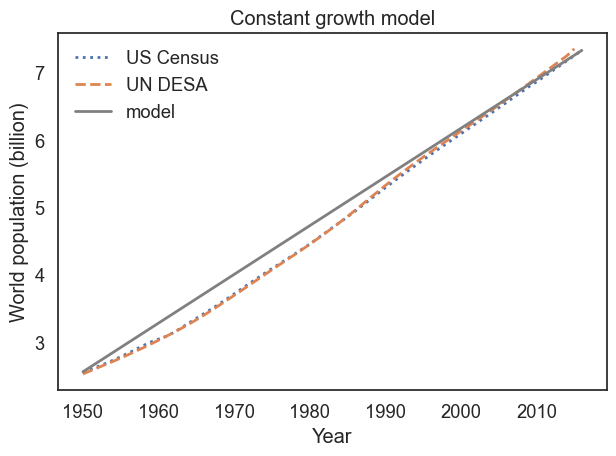

In [66]:
results = run_simulation1(system)
plot_results(census, un, results, 'Constant growth model')

## Proportional growth

Here's a more realistic model where the number of births and deaths is proportional to the current population.

In [67]:
def run_simulation2(system):
    """Run a model with proportional birth and death.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

I picked a death rate that seemed reasonable and then adjusted the birth rate to fit the data.

In [68]:
system.death_rate = 0.01
system.birth_rate = 0.027

Here's what it looks like.

Saving figure to file figs/chap06-fig01.pdf


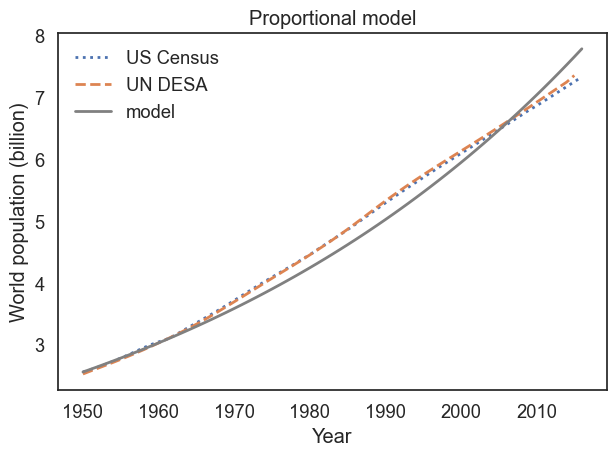

In [69]:
results = run_simulation2(system)
plot_results(census, un, results, 'Proportional model')
savefig('figs/chap06-fig01.pdf')

The model fits the data pretty well for the first 20 years, but not so well after that.

### Factoring out the update function

`run_simulation1` and `run_simulation2` are nearly identical except the body of the loop.  So we can factor that part out into a function.

In [70]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

The name `update_func` refers to a function object.

In [71]:
update_func1

<function __main__.update_func1(pop, t, system)>

Which we can confirm by checking its type.

In [72]:
type(update_func1)

function

`run_simulation` takes the update function as a parameter and calls it just like any other function.

In [73]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

Here's how we use it.

In [74]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                birth_rate=0.027,
                death_rate=0.01)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
birth_rate,0.027000
death_rate,0.010000


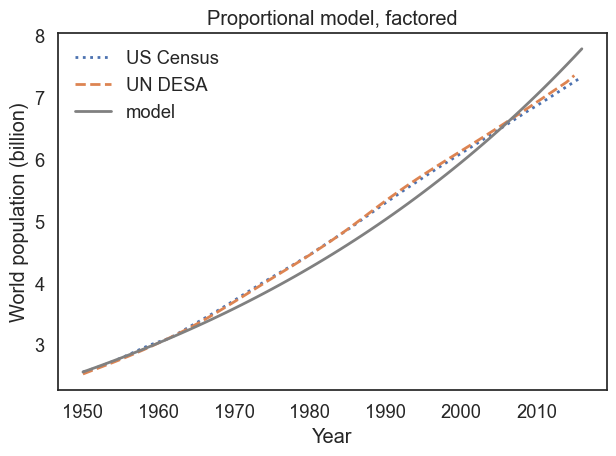

In [75]:
results = run_simulation(system, update_func1)
plot_results(census, un, results, 'Proportional model, factored')

Remember not to put parentheses after `update_func1`.  What happens if you try?

**Exercise:** When you run `run_simulation`, it runs `update_func1` once for each year between `t_0` and `t_end`.  To see that for yourself, add a print statement at the beginning of `update_func1` that prints the values of `t` and `pop`, then run `run_simulation` again.

In [76]:
#results = run_simulation(system, update_func1())
# Placing parenthesis afterwards will not pass on the currently existing variables and ask for more, creating an error
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    print(f"This is the year: {t}")
    print(f"This is population size: {pop}")
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

run_simulation(system,update_func1)

This is the year: 1950
This is population size: 2.557628654
This is the year: 1951
This is population size: 2.601108341118
This is the year: 1952
This is population size: 2.645327182917006
This is the year: 1953
This is population size: 2.6902977450265952
This is the year: 1954
This is population size: 2.7360328066920476
This is the year: 1955
This is population size: 2.7825453644058125
This is the year: 1956
This is population size: 2.829848635600711
This is the year: 1957
This is population size: 2.8779560624059233
This is the year: 1958
This is population size: 2.926881315466824
This is the year: 1959
This is population size: 2.9766382978297603
This is the year: 1960
This is population size: 3.0272411488928666
This is the year: 1961
This is population size: 3.078704248424045
This is the year: 1962
This is population size: 3.131042220647254
This is the year: 1963
This is population size: 3.184269938398258
This is the year: 1964
This is population size: 3.2384025273510284
This is the 

,values
1950,2.557629
1951,2.601108
1952,2.645327
1953,2.690298
1954,2.736033
...,...
2012,7.273385
2013,7.397032
2014,7.522782
2015,7.650669


### Combining birth and death

Since births and deaths get added up, we don't have to compute them separately.  We can combine the birth and death rates into a single net growth rate.

In [77]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha  * pop
    return pop + net_growth

Here's how it works:

In [78]:
system

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
birth_rate,0.027000
death_rate,0.010000


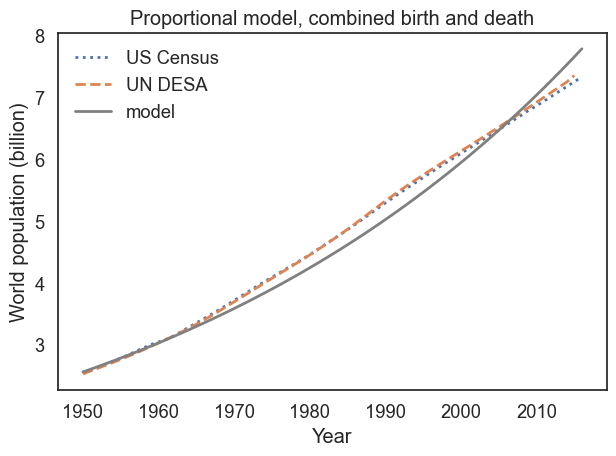

In [79]:
system.alpha = system.birth_rate - system.death_rate

results = run_simulation(system, update_func2)
plot_results(census, un, results, 'Proportional model, combined birth and death')

In [80]:
system.alpha

0.017

### Exercises

**Exercise:** Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write an update function that takes `pop`, `t`, and `system` as parameters.  The system object, `system`, should contain two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should use `t` to determine which growth rate to use.  Note: Don't forget the `return` statement.

Test your function by calling it directly, then pass it to `run_simulation`.  Plot the results.  Adjust the parameters `alpha1` and `alpha2` to fit the data as well as you can.



In [101]:
##Pre 80 Generation
t_0 = get_first_label(census)
t_80end = 1980
elapsed_time_pre80 = t_80end - t_0

p_0 = get_first_value(census)
p_80end = census.loc[1980]
total_growth_pre80 = p_80end - p_0

annual_growth_pre80 = total_growth_pre80 / elapsed_time_pre80

#Post 80 Generation
t_1981 = 1981
t_end = get_last_label(census)
elapsed_time_post80 = t_end - t_1981

p_1981 = census.loc[1981]
p_end = get_last_value(census)
total_growth_post80 = p_end - p_1981

annual_growth_post80 = total_growth_post80 / elapsed_time_post80

display(annual_growth_pre80,annual_growth_post80, annual_growth)

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha1= annual_growth_pre80 ,
                alpha2= annual_growth_post80
               )

display(system.alpha1)

print(f"This was total growth pre80: {total_growth_pre80}")
print(f"and elapsed time: {elapsed_time_pre80}")
print(f"and annual growth pre80: {annual_growth_pre80}")

print(f"This was total growth post80: {total_growth_post80}")
print(f"and elapsed time: {elapsed_time_post80}")
print(f"and annual growth post80: {annual_growth_post80}")

census

0.06312446936666666

0.07975961668571428

0.07224800083333333

0.06312446936666666

This was total growth pre80: 1.8937340809999998
and elapsed time: 30
and annual growth pre80: 0.06312446936666666
This was total growth post80: 2.791586584
and elapsed time: 35
and annual growth post80: 0.07975961668571428


Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
1955    2.782099
1956    2.835300
1957    2.891350
1958    2.948137
1959    3.000717
1960    3.043002
1961    3.083967
1962    3.140093
1963    3.209828
1964    3.281201
1965    3.350426
1966    3.420678
1967    3.490334
1968    3.562314
1969    3.637159
1970    3.712698
1971    3.790327
1972    3.866569
1973    3.942096
1974    4.016609
1975    4.089083
1976    4.160185
1977    4.232085
1978    4.304106
1979    4.379014
1980    4.451363
1981    4.534410
1982    4.614567
1983    4.695737
1984    4.774569
1985    4.856463
1986    4.940571
1987    5.027200
1988    5.114557
1989    5.201440
1990    5.288956
1991    5.371586
1992    5.456136
1993    5.538268
1994    5.618682
1995    5.699203
1996    5.779441
1997    5.857973
1998    5.935213
1999    6.012075
2000    6.088571
2001    6.165219
2002    6.242016
2003    6.318591
2004    6.395700
2005    6.473045
2006    6.551264
2007    6.629914
2008    6

In [102]:
# Solution goes here

##Pre 80 Generation
t_0 = get_first_label(census)
t_80end = 1980
elapsed_time_pre80 = t_80end - t_0

p_0 = get_first_value(census)
p_80end = census.loc[1980]
total_growth_pre80 = p_80end - p_0

annual_growth_pre80 = total_growth_pre80 / elapsed_time_pre80

#Post 80 Generation
t_1981 = 1981
t_end = get_last_label(census)
elapsed_time_post80 = t_end - t_1981

p_1981 = census.loc[1981]
p_end = get_last_value(census)
total_growth_post80 = p_end - p_1981

annual_growth_post80 = total_growth_post80 / elapsed_time_post80



system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha1= annual_growth_pre80 ,
                alpha2= annual_growth_post80
               )


def update_func3(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    if t < 1981:
        net_growth = system.alpha1
    else:
        net_growth = system.alpha2
        
    return pop + net_growth


def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        
        results[t+1] = update_func3(results[t], t, system)
        
    return results

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
alpha1,0.063124
alpha2,0.079760


,values
1950,2.557629
1951,2.620753
1952,2.683878
1953,2.747002
1954,2.810127
1955,2.873251
1956,2.936375
1957,2.999500
1958,3.062624
1959,3.125749


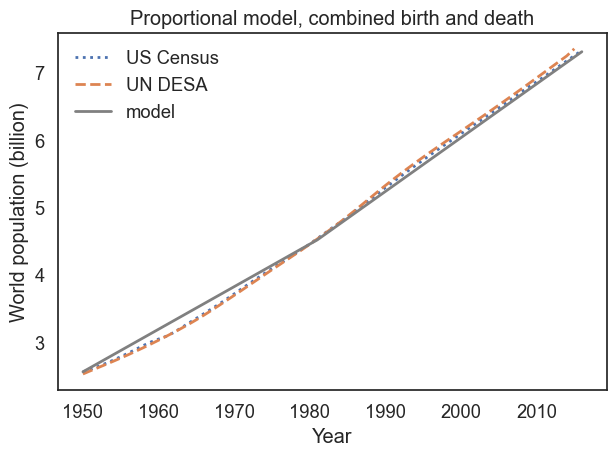

In [103]:
# Solution goes here
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
results = run_simulation(system, update_func3)
plot_results(census, un, results, 'Proportional model, combined birth and death')
display(system)
display(results)